In [1]:
# Classical import
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
import geotorch

# Quantum import
from qiskit import Aer, QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA
from qiskit_machine_learning.connectors import TorchConnector

from qiskit_machine_learning.neural_networks import TwoLayerQNN

In [75]:
plt.rcdefaults() # Need to use sometimes due to dark mode issues.

In [78]:
def data_processer(data, pca=False, multiplier=2):
    """
    tuple data: Takes sklearn dataset and returns data standarised and split. 
    return_X_y must be set to True!
    int pca: How many dimensions to reduce too.
    int multiplier: size of training size depending on (multiplier * dimension of features).
    """
    X, y = data
    scaler = StandardScaler().fit(X)
    standardised_X = scaler.transform(X)
    
    # Option to perform PCA.
    if pca:
        pca = PCA(n_components=pca)
        pca.fit(standardised_X)
        X = pca.transform(standardised_X)
#         global variance_per_component
#         variance_per_component = pca.explained_variance_ratio_
        dim = X.shape[1]
    else:
        dim = X.shape[1] # number of original features in the data.
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = int(multiplier*dim))
    
    # Covert to tensors for PyTorch.
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()

    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()
    
    return X_train, X_test, y_train, y_test

# Load data and use same training size as VQC.
# Remainder of data is used for test. Must have those variable names!
X_train, X_test, y_train, y_test = data_processer(load_breast_cancer(return_X_y=True), pca=30, 
                                                 multiplier=2)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Create an imbalanced data set.
# minority_class_num = round(len(X_train) * 0.1) # How many minority class instances we want.
# label_0 = X_train[y_train == 0][:minority_class_num] 
# label_1 = X_train[y_train == 1] # However many ones there were in the initial split.
# X_train = np.vstack((label_0, label_1))
# y_train = np.array([0 for i in range(len(label_0))] + [1 for j in range(len(label_1))])

torch.Size([60, 30]) torch.Size([60])
torch.Size([509, 30]) torch.Size([509])


In [ ]:
#### Check class imbalance.
print(f'0: {int(sum(y_train == 0))} 1: {int(sum(y_train == 1))}')
print(f'0: {int(sum(y_test == 0))} 1: {int(sum(y_test == 1))}')

hist_data, count = np.unique(np.append(y_train, y_test, axis=0), return_counts=True)

with plt.style.context('seaborn-colorblind'):
    plt.bar(hist_data, count, align='center')
    plt.xticks(hist_data)
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Distribution of Breast Cancer Data")
    plt.annotate("100%", (0.95,360))
    plt.annotate("{}%".format(int(count[0]/count[1] * 100)), (-0.02,220))
#     plt.savefig("data-distribution.png", dpi=200)

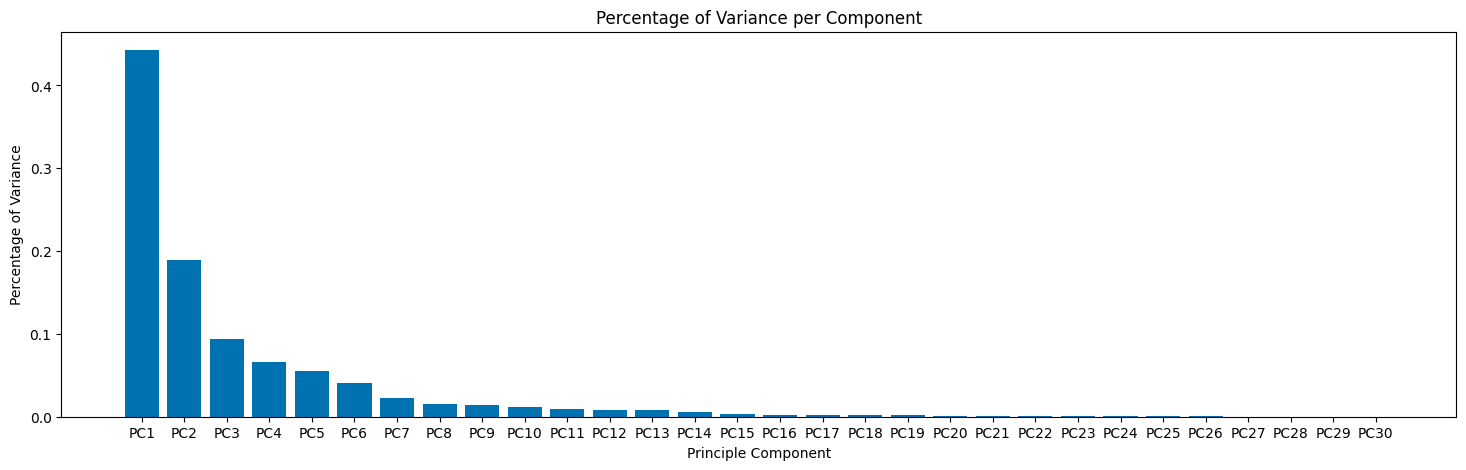

In [138]:
# Variance explained by each component for PCA.
components = list(range(1,31))

with plt.style.context("seaborn-colorblind"):
    plt.figure(figsize=(18,5))
    plt.bar(components, variance_per_component)
    plt.xticks(components, ["PC{}".format(i) for i in components])
    plt.xlabel("Principle Component")
    plt.ylabel("Percentage of Variance")
    plt.title("Percentage of Variance per Component")
#     plt.savefig("pca-variance.png", dpi=200)

In [4]:
class OCHQNN(nn.Module):
    
    def __init__(self, n_features, qdim, depth, classical, orthogonal):
        super().__init__()
        """
        For now – same dimensions for both classical layers and quantum layer.
        """
        self.classical = classical
        self.orthogonal = orthogonal
        self.qdim = qdim # input dimension into quantum layer. 
        self.depth = depth # minimum 2 if quantum.
        # All layers are classical linear layers. Otherwise (n-1) layers implemented.
        if classical:
            self.linears = \
            nn.ModuleList([nn.Linear(n_features, n_features) for i in range(depth)])
        else:
            if n_features != qdim:
                self.linears = \
                nn.ModuleList([nn.Linear(n_features, n_features) for i in range(depth - 2)] +
                             [nn.Linear(n_features, qdim)])
            else:
                self.linears = \
                nn.ModuleList([nn.Linear(n_features, n_features) for i in range(depth - 1)])
             # Last layer is the quantum layer.
            self.quantum_layer = TorchConnector(ql)
            
        # Impose orthogonality constraint on the weight matrices.
        if orthogonal:
            for j in self.linears:
                geotorch.orthogonal(j, "weight")
                
                
    def forward(self, x):
        if self.classical:
            for i in range(len(self.linears)):
                x = F.relu(self.linears[i](x))
            return torch.sigmoid(self.linears[-1](x))
        else:
            for ii in self.linears:
                x = F.relu(ii(x))
                # Sigmoid applied to output of quantum layer.
            return torch.sigmoid(self.quantum_layer(x))

In [5]:
def tensor_confusion_mat(y_true, y_pred):
    """
    Return confusion matrix for tensor objects. Uses sklearn implementation.
    """
    y_true = y_true.long().tolist()
    y_pred = y_pred.round().long().tolist()
    
    return confusion_matrix(y_true, y_pred)

def tensor_f1_score(y_true, y_pred):
    """
    Return f1 score for tensor objects using sklearn implementation. 0.5 is the threshold.
    """
    y_true = y_true.long().numpy()
    y_pred = y_pred.round().long().numpy()
    
    return f1_score(y_true, y_pred)

In [6]:
# Defining quantum instance
ideal_sim = QuantumInstance(Aer.get_backend('aer_simulator'))

In [7]:
# Define quantum layer. Keeping reps low for improved computation time.
feature_map = ZZFeatureMap(2, reps=1)
ansatz = TwoLocal(2, rotation_blocks='ry', entanglement_blocks='cx', entanglement='linear',
                 reps=1)
ql = TwoLayerQNN(num_qubits=2, feature_map=feature_map, ansatz=ansatz, input_gradients=True,
                 quantum_instance=ideal_sim) # must be named ql, otherwise will not work!!
print(feature_map)
print(ansatz)

     ┌───┐┌──────────────┐                                           
q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──
     ├───┤├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
     └───┘└──────────────┘└───┘└───────────────────────────────┘└───┘
     ┌──────────┐     ┌──────────┐
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2]) ├
     ├──────────┤┌─┴─┐├──────────┤
q_1: ┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[3]) ├
     └──────────┘└───┘└──────────┘


In [8]:
def train(depth, classical=False, orthogonal=True, epochs=1000, lr=0.001, verbose=False):
    """
    int depth: Network depth including input and output layer.
    Boolean: classical, orthogonal
    int iterations: number of times to reinitialise and repeat train.
    int epochs: epochs+1 should be provided to get most recent test data evaluation.
    float lr: learning rate.
    """
    # List holding the PyTorch model with the lowest loss, its f1 score and loss per epoch.
    best_model = [0,100,0,[]] # Third value is the loss of that model.
    
    #  Initialise our OCQNN with random weights.
    model = OCHQNN(X_train.shape[1], ql.num_qubits, depth=depth, classical=classical, 
                  orthogonal=orthogonal)

    criterion = nn.BCELoss()

    optimiser = optim.Adam(model.parameters(), lr=lr)

    # Training loop.
    for epoch in range(epochs):

        y_pred = model(X_train)
        # To meet sqaure weight matrix requirement ignore the output of (n-1) nodes
        # and optimise based on the ouput of the first node only.
        if classical:
            loss = criterion(y_pred[:,0], y_train)
        else:
            # Now the output is one node because of the quantum layer.
            loss = criterion(torch.flatten(y_pred), y_train)

        if epoch % (epochs // 10) == 0:
            y_test_pred = model(X_test)
            if classical:
                test_loss = criterion(y_test_pred[:,0], y_test)
            else:
                test_loss = criterion(torch.flatten(y_test_pred), y_test)
            if test_loss < best_model[1]:
                best_model[0] = model # Save best model.
                # save f1 score of best model.
                if classical:
                    best_model[2] = tensor_f1_score(y_test, y_test_pred[:,0])
                else:
                    best_model[2] = tensor_f1_score(y_test, torch.flatten(y_test_pred))

                best_model[1] = test_loss #update best loss.

            best_model[3].append(test_loss.item()) #Append test loss at that point.

        optimiser.zero_grad() # Reset gradients to prepare for backward pass.
        loss.backward() # backward pass.
        optimiser.step() # update parameters.
    
    if verbose:
        print(f'best_loss: {best_model[1]}')
        
    return best_model

In [100]:
# Two linear layers and one quantum layer of all same size expect quantum outputs one node.
quantum_orthogonal_classifier = train(3, epochs=101, lr=0.1, verbose=True)

best_loss: 0.4828587770462036


In [101]:
quantum_hyrid_classifier = train(3, orthogonal=False, epochs=101, lr=0.01, verbose=True)

best_loss: 0.4754972457885742


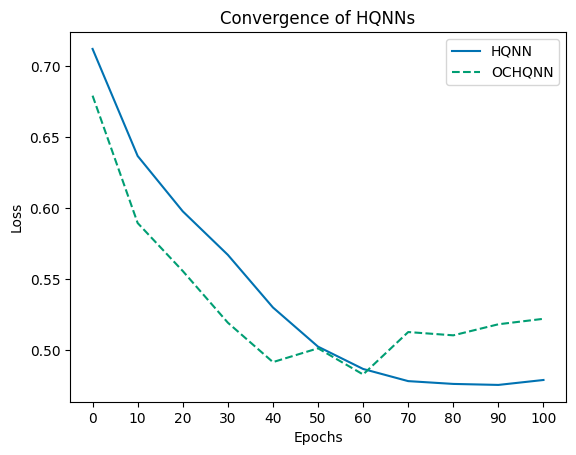

In [153]:
with plt.style.context("seaborn-colorblind"):
    plt.plot(range(0,101,10), quantum_hyrid_classifier[3],
            label="HQNN")
    plt.plot(range(0,101,10), quantum_orthogonal_classifier[3],
            '--', label="OCHQNN")
    plt.xticks(range(0,101,10))
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Convergence of HQNNs")
    plt.legend()
#     plt.savefig("hqnn-convergence.png", dpi=200)

Best result with learning rate and parameters you see above. Adding another classical hidden layer didn't improve results.

In [140]:
# quantum_orthogonal_classifier2 = train(3, epochs=101, lr=0.01, verbose=True)

best_loss: 0.5358665585517883


In [190]:
# Four linear layers all same size.
orthogonal_classifier = train(3, classical=True, epochs=101, lr=0.0002, verbose=True)
orthogonal_classifier[2]

best_loss: 0.5251027345657349


0.9276218611521417

In [139]:
standard_classifier = train(3, classical=True, orthogonal=False, epochs=101, lr=0.001, verbose=True)
standard_classifier[2]

best_loss: 0.11261853575706482


0.9723926380368098

In [51]:
"""
Plot a histogram of all the values where the model converged. Also print standard deviation to
numerically show result.
"""
converged_to_stan = []
converged_to_orth = []

for _ in range(10):
    standard_classifier = train(3, classical=True, orthogonal=False, epochs=101, lr=0.001)
    orthogonal_classifier = train(3, classical=True, epochs=101, lr=0.1)

    converged_to_stan.append(np.array(standard_classifier[3]))
    converged_to_orth.append(np.array(orthogonal_classifier[3]))
    
def splitter(x):
    """
    Split values by epoch so we can calculate the std for each epoch value.
    """
    lst = []

    for i in range(len(x[0])):
        splitted = np.empty(len(x))
        for ii in range(len(splitted)):
            splitted[ii] = x[ii][i]
        lst.append(splitted)
        
    return lst

standard_std = [np.std(i) for i in splitter(converged_to_stan)]
orthogonal_std = [np.std(i) for i in splitter(converged_to_orth)]

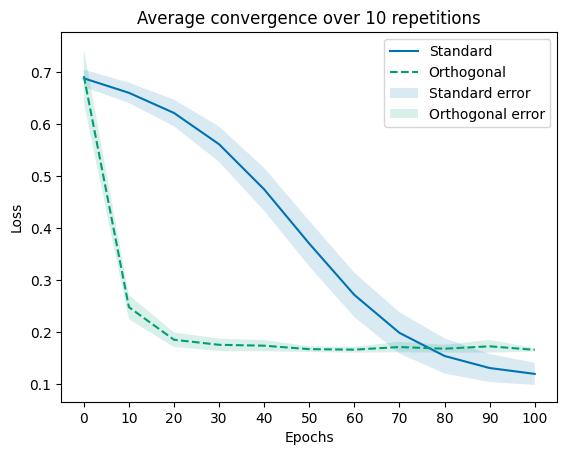

In [57]:
"""
Convergence properties of both standard and orthogonal neural networks. Uses results from error
calculation above. Run before running this.
"""
def operation(x, y, add):
    """
    Subtract element-wise list x and list y.
    add Boolean: whether you want to add or subtract.
    """
    if add:
        result = np.asarray(x) + np.asarray(y)
        return result
    else:
        result = np.asarray(x) - np.asarray(y)
        return result
    
epochs = [i for i in range(0,101,10)]
standard_results = [np.mean(i) for i in splitter(converged_to_stan)]
orthogonal_results = [np.mean(i) for i in splitter(converged_to_orth)]

with plt.style.context('seaborn-colorblind'):
    plt.plot(epochs, standard_results, label = "Standard")
    plt.plot(epochs, orthogonal_results, '--', label = "Orthogonal")
    plt.fill_between(epochs, operation(standard_results, standard_std, False),
                     operation(standard_results, standard_std, True), alpha=0.15, 
                     label = 'Standard error')
    plt.fill_between(epochs, operation(orthogonal_results, orthogonal_std, False),
                     operation(orthogonal_results, orthogonal_std, True), alpha=0.15, 
                     label = 'Orthogonal error')
    plt.xticks(epochs)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Average convergence over 10 repetitions")
    plt.legend()
#     plt.savefig("classical-convergence.png", dpi=200)

In [129]:
# Perform PCA sweep to show that PCA will vary performance.
# dimensions_to_test = [i for i in range(2,30,2)] + [False]
dimensions_to_test = list(range(2,31,2))

results1 = []
results2 = []

for _ in range(3):
    results1_tmp = []
    results2_tmp = []
    for ii in dimensions_to_test:
        X_train, X_test, y_train, y_test = data_processer(load_breast_cancer(return_X_y=True), pca=ii)

        standard_classifier = train(3, classical=True, orthogonal=False, epochs=101, lr=0.001)
        orthogonal_classifier = train(3, classical=True, epochs=101, lr=0.1)

        results1_tmp.append(standard_classifier[2]*100)
        results2_tmp.append(orthogonal_classifier[2]*100)
        
    results1.append(results1_tmp)
    results2.append(results2_tmp)
    


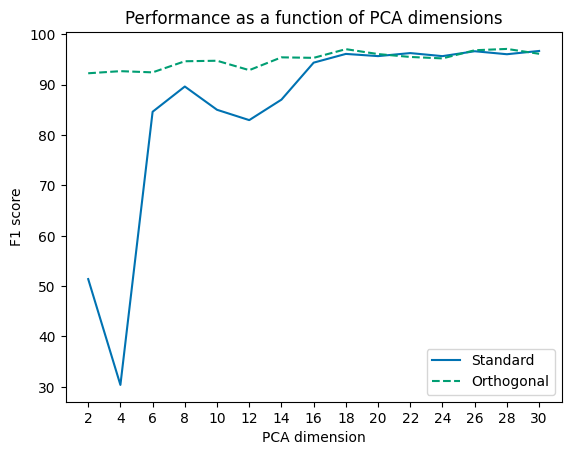

In [136]:
results1_mean = [np.mean(i) for i in splitter(results1)]
results2_mean = [np.mean(i) for i in splitter(results2)]
    
with plt.style.context('seaborn-colorblind'):
    plt.plot(dimensions_to_test, results1_mean, label = "Standard")
    plt.plot(dimensions_to_test, results2_mean, '--', label = "Orthogonal")
    plt.title("Performance as a function of PCA dimensions")
    plt.xlabel("PCA dimension")
    plt.ylabel("F1 score")
    plt.xticks(dimensions_to_test)
    plt.legend()
#     plt.savefig("pca-sweep.png", dpi=200)

Findings: Performance is the same regardless of one output node, two or constraints on one or two output nodes for PCA dimensions = 2. Just a bit better without constraint, converges more consistently. Same for PCA_dim = 10. Same for PCA_dim = 30. Conclusion: No difference regardless of what I do. Possibly, not deep enough and vanishing gradient isn't really a problem so orthogonal cannot do any better than the normal: even if we go deep. Tested up to 96 layers.

ANOMOLY DETECTED: For some reason pca of dimension 30 (original dimension of data) provides much better results than non-pca results.

Emperically we find 100x learning rate to equal classical.